<a href="https://colab.research.google.com/github/andresperez86/EntregasDL/blob/master/Handling_Imbalanced_Data_Over_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deseafio Kaggle Detección de fraude con tarjeta de crédito : fijación de conjuntos de datos desequilibrados

### Contexto
Es importante que las compañías de tarjetas de crédito puedan reconocer transacciones fraudulentas de tarjetas de crédito para que a los clientes no se les cobre por los artículos que no compraron.

### Contenido
Los conjuntos de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos. Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284,807 transacciones. El conjunto de datos está altamente desequilibrado, la clase positiva (fraudes) representa el 0.172% de todas las transacciones.

Contiene solo variables de entrada numéricas que son el resultado de una transformación con Análisis de componentes pricipales(PCA). Desafortunadamente, debido a problemas de confidencialidad, no podemos proporcionar las características originales y más información de fondo sobre los datos. Las características V1, V2, ... V28 son los componentes principales obtenidos con PCA, las únicas características que no se han transformado con PCA son 'Tiempo' y 'Cantidad'. La función 'Tiempo' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La característica 'Cantidad' es la Cantidad de la transacción, esta característica se puede utilizar para el aprendizaje sensible al costo dependiente del ejemplo. La característica 'Clase' es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

### Inspiracion
Identificar transacciones fraudulentas con tarjeta de crédito.

Dada la relación de desequilibrio de clase, recomendamos medir la precisión utilizando el área bajo la curva de precisión-recuperación (AUPRC). La precisión de la matriz de confusión no es significativa para la clasificación desequilibrada.

### Agradecimientos.
El conjunto de datos se ha recopilado y analizado durante una colaboración de investigación de Worldline y el Machine Learning Group (http://mlg.ulb.ac.be) de ULB (Université Libre de Bruxelles) sobre minería de datos grandes y detección de fraude. Más detalles sobre proyectos actuales y pasados sobre temas relacionados están disponibles en https://www.researchgate.net/project/Fraud-detection-5 y la página del proyecto DefeatFraud

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_curve, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
# rcParams['figure.figsize'] = 20, 8 
RANDOM_SEED = 42
LABELS = ["Not Fraud", "Fraud"]

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
!mkdir ./local/
!mkdir ./local/datasets/

mkdir: cannot create directory ‘./local/’: File exists
mkdir: cannot create directory ‘./local/datasets/’: File exists


In [0]:
ruta_zip='/content/drive/My Drive/MAESTRÍA/STATISTICAL LEARNING/Imbalance Learning/creditcard.csv.zip'
dataset_dir = "./local/datasets/"
password = None

In [7]:
import zipfile

archivo_zip = zipfile.ZipFile(ruta_zip, "r")
try:
    print(archivo_zip.namelist())
    archivo_zip.extractall(pwd=password, path=dataset_dir)

except:
    pass
archivo_zip.close()

['creditcard.csv']


In [8]:
data = pd.read_csv(dataset_dir+'creditcard.csv',sep=',')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [10]:
print(data.Class.value_counts())

0    284315
1       492
Name: Class, dtype: int64


In [97]:
#Separamos las caracteristicas independientes de las dependientes
columns = data.columns.tolist()
#filtramos la columna para remover e dato no deseado
columns = [c for c in columns if c not in ["Class"]]
# almacenamos la variable que estamoos prediciendo 
target = "Class"
# Definimos un estado aleatorio
state = np.random.RandomState(42)
X = data[columns]
Y = data[target]
# Se imprime X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


In [0]:
def plot_roc_auc(fpr, tpr):
  plt.figure(figsize=[12,6])
  plt.grid(color='k', linestyle='--', linewidth=1)
  plt.plot(fpr, tpr, color='orange', label='ROC')
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('Razon de falsos posivos')
  plt.ylabel('Razon de verdaderos positivos')
  plt.title('Receiver operating characterics(ROC) curve')
  plt.legend()
  plt.show()

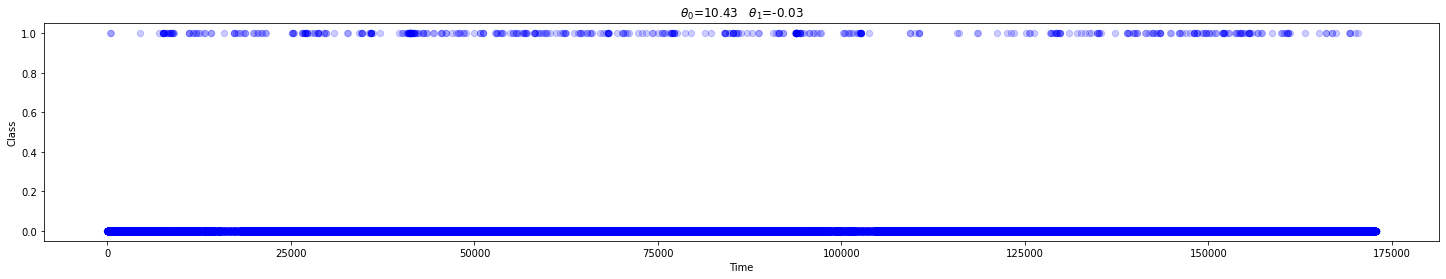

In [99]:
def plot_model(t ):#prediction
    xr = np.linspace(np.min(data.Time), np.max(data.Time), 100)
    plt.figure(figsize=[25,4])
    plt.scatter(data.Time, data.Class, s=40, alpha=.2, color="blue", label="")
    plt.title("   ".join([r"$\theta_%d$=%.2f"%(i, t[i]) for i in range(len(t))]));
    plt.xlabel(data.columns[0])
    plt.ylabel(data.columns[30]);
    
t0 = np.random.random()*5+10
t1 = np.random.random()*4-3

plot_model([t0,t1])#, linear_prediction

## Exploratory Data Analysis

Text(0, 0.5, 'Frequency')

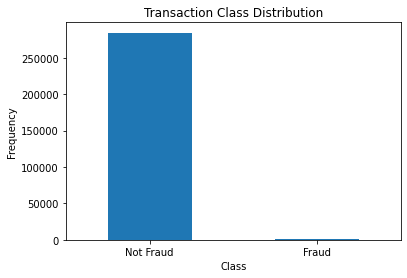

In [100]:
# configuración predeterminada de parametros de la grafica.
%matplotlib inline
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [101]:
# imprimir porcentaje de clases donde la salida es == 1 osea que es fraude
(len(data.loc[data.Class==1])) / (len(data.loc[data.Class == 0])) * 100

0.17304750013189596

En el gráfico anterior, podemos ver que tenemos una base de datos muy  desequilibrada: ¡solo el 0.17% de nuestro conjunto de datos pertenece a la clase objetivo!

Esto es un problema, porque muchos modelos de aprendizaje automático están diseñados para maximizar la precisión general, que especialmente con clases desequilibradas puede no ser la mejor métrica para usar. La precisión de clasificación se define como el número de predicciones correctas dividido por el total de predicciones multiplicado por 100. Por ejemplo, si simplemente predijiéramos que todas las transacciones no son fraude, obtendríamos un puntaje de precisión de clasificación de más del 99%.

Create Train and Test Sets

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=27)
X_train.shape

(213605, 30)

Baseline Models


In [0]:
# DummyClassifier para predecir solo la clase  0(no fraude)
dummy = DummyClassifier(strategy='most_frequent')
dummy = dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)

In [104]:
# Encuentra los elementos únicos de una matriz.
print('Unique predicted labels: ', (np.unique(dummy_pred)))
# Verifica exactitud
print('Test score: ', accuracy_score(y_test, dummy_pred))

Unique predicted labels:  [0]
Test score:  0.9981461194910255



¡Predijimos que nuestro puntaje de exactitud para clasificar todas las transacciones como no fraude es del 99.8%!

Como el Dummy Classifier predice solo la Clase 0, claramente no es una buena opción para nuestro objetivo de clasificar correctamente las transacciones fraudulentas.

Veamos cómo se realiza la regresión logística en este conjunto de datos.

In [0]:
lr = LogisticRegression(solver='liblinear')
lr = lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_pp = lr.predict_proba(X_train)

In [20]:
lr_pp1  = lr_pp[:,1]
auc = roc_auc_score(y_train, lr_pp1)#funcion para encontrar el auc
print('AUC: %.2f' % auc)

AUC: 0.94


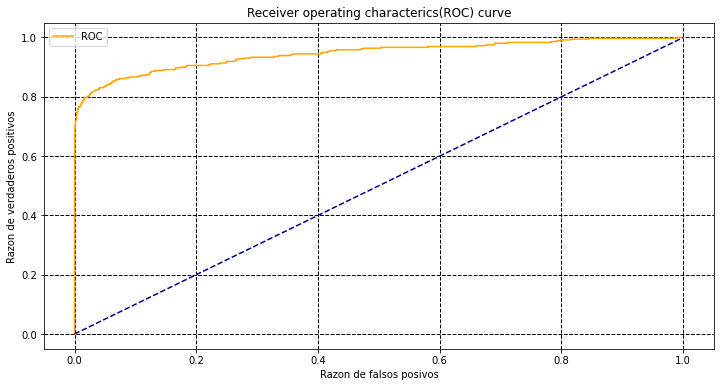

In [21]:
frp, tpr, threshold = roc_curve(y_train, lr_pp1)
plot_roc_auc(frp, tpr)

In [22]:
# verificamos Precisión
accuracy_score(y_test, lr_pred)

0.9991011488441336

In [23]:
# Verificamos valores unico
predictions = pd.DataFrame(lr_pred)
predictions[0].value_counts()

0    71114
1       88
Name: 0, dtype: int64

¡La regresión logística superó al clasificador ficticio! Podemos ver que predijo 88 instancias de la clase 1, por lo que definitivamente es una mejora. ¿Pero podemos hacerlo mejor?

Veamos si podemos aplicar algunas técnicas para tratar el desequilibrio de clase para mejorar estos resultados.


##Cambiar la métrica de rendimiento

La precisión no es la mejor métrica para usar al evaluar conjuntos de datos desequilibrados, ya que puede ser engañoso. Las métricas que pueden proporcionar una mejor información incluyen:


*   **Matriz de confusión:**es una tabla con dos filas y dos columnas que informa el número de falsos positivos , falsos negativos , verdaderos positivos y verdaderos negativos. Esto permite un análisis más detallado que solo la proporción de clasificaciones correctas (precisión). La precisión producirá resultados engañosos si el conjunto de datos no está equilibrado.
*   **Precisión:** el número de verdaderos positivos dividido por todas las predicciones positivas. La precisión también se llama valor predictivo positivo. Es una medida de la exactitud de un clasificador. La baja precisión indica un alto número de falsos positivos.
*   **Recordar (Sensitivity):** el número de verdaderos positivos dividido el número de valores positivos en los datos de la prueba. La recuperación también se llama Sensibilidad o la tasa positiva verdadera(TPR). Es una medida de la integridad de un clasificador. La baja recuperación indica un alto número de falsos negativos.
*   **F1: Puntuación:** el promedio ponderado de precisión y recuperación.

Dado que nuestro objetivo principal con el conjunto de datos es priorizar la clasificación precisa de los casos de fraude, la metrica  de recardar( sensivilidad) puede considerarse nuestra principal métrica para evaluar los resultados.


In [24]:
# f1 score
f1_score(y_test, lr_pred)

0.7090909090909092

Confusion matrix, without normalization
[[71060    10]
 [   54    78]]
Normalized confusion matrix
[[9.99859294e-01 1.40706346e-04]
 [4.09090909e-01 5.90909091e-01]]


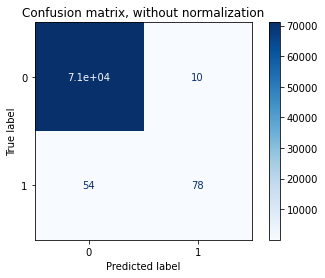

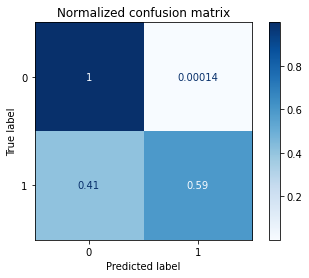

In [25]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=['0','1'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [26]:
recall_score(y_test, lr_pred)

0.5909090909090909

Tenemos una puntuación de precisión muy alta de 0.999 pero una puntuación de F1 de solo 0.752. Y a partir de la matriz de confusión, podemos ver que estamos clasificando erróneamente varias observaciones que conducen a una puntuación de recuerdo de solo 0.64.

#Change the algorithm

Si bien en cada problema de aprendizaje automático, es una buena regla general probar una variedad de algoritmos, puede ser especialmente beneficioso con conjuntos de datos desequilibrados. Los árboles de decisión con frecuencia funcionan bien en datos desequilibrados. Trabajan aprendiendo una jerarquía de preguntas if / else. Esto puede obligar a que se aborden ambas clases

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
# entrenamos el modelo  
rfc = RandomForestClassifier(n_estimators=10)
rfc = rfc.fit(X_train, y_train)

# prediciones en el conjunto de prueba 
rfc_pred = rfc.predict(X_test)
rfc_pp = rfc.predict_proba(X_test)


In [29]:
rfc_pp=rfc_pp[:,1]
auc = roc_auc_score(y_test, rfc_pp)#funcion para encontrar el auc
print('AUC: %.2f' % auc)

AUC: 0.92


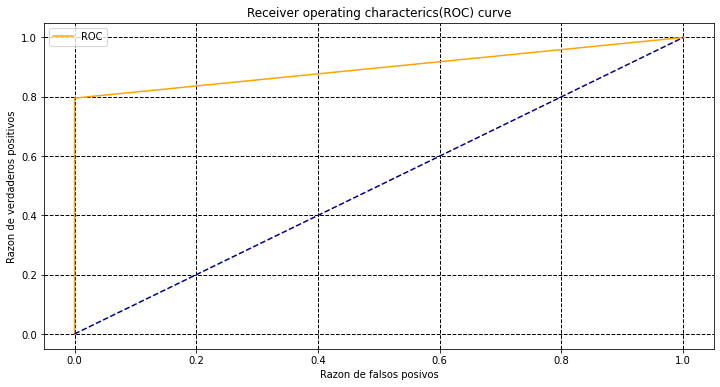

In [30]:
frp, tpr, threshold = roc_curve(y_test, rfc_pred)
plot_roc_auc(frp, tpr)

In [31]:
# Verificamos la exactitud
accuracy_score(y_test, rfc_pred)

0.999592708069998

In [32]:
# f1 score
f1_score(y_test, rfc_pred)

0.8786610878661087

Confusion matrix, without normalization
[[71068     2]
 [   27   105]]
Normalized confusion matrix
[[9.99971859e-01 2.81412692e-05]
 [2.04545455e-01 7.95454545e-01]]


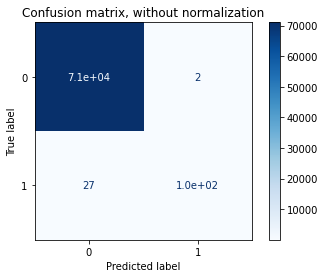

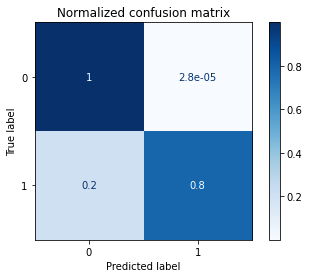

In [33]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rfc, X_test, y_test, display_labels=['0','1'], cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title) 
    print(title)
    print(disp.confusion_matrix)

plt.show()

In [34]:
# recall score
recall_score(y_test, rfc_pred)

0.7954545454545454

#Tecnicas de remuestreo



#Sobremuestreo de minorias 
El sobremuestreo se puede definir como agregar más copias de la clase minoritaria. El sobremuestreo puede ser una buena opción cuando no tienes muchos datos para trabajar. Una desventaja a tener en cuenta al submuestrear es que puede causar un sobreajuste y una generalización deficiente en su conjunto de prueba.

Utilizaremos el módulo de remuestreo de Scikit-Learn para replicar aleatoriamente muestras de la clase minoritaria

**Nota:** para evitar que el modelo memorice los datos y cause sobreajuste, debemos dividir los datos, en datos de entrenamiento y datos de prueba antes de realizar el sobremuestreo 

In [0]:
from sklearn.utils import resample

In [36]:
# concatenar nuestros datos de entrenamiento nuevamente
X = pd.concat([X_train, y_train], axis=1)
X.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,-0.343885,-0.647990,-0.509490,-0.633729,-0.712156,0.765701,0.053830,0.526211,0.750505,-0.225921,0.054132,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,0.443750,0.257633,0.358875,-1.313311,0.922108,-1.078538,-0.395038,-0.437151,0.074223,0.187086,-0.285207,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,-0.113006,1.263824,1.017046,-0.791270,0.181033,-0.530067,-0.733662,0.436861,-0.903134,-0.242185,-0.226981,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,0.334537,1.016183,-0.510443,-0.748733,-2.708662,-1.014069,2.220866,1.285249,1.619087,-1.602343,-0.150818,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,0.754427,0.513247,0.704388,0.472193,-0.072043,-0.357247,-1.136932,-0.436168,2.047641,-0.775130,-0.045313,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [0]:
# Obtenga el Fraude y el conjunto de datos no fraude
fraud = X[X['Class']==1]
not_fraud = X[X['Class']==0]

In [38]:
print(fraud.shape,not_fraud.shape)

(360, 31) (213245, 31)


In [0]:
# muestreamos la minoria
fraud_upsampled = resample(fraud, 
                          replace=True, # remplazamos las muestras
                          n_samples=len(not_fraud), # Igualamos el numero en la clase mayoritaria
                          random_state=state ) # resultados reproducibles

In [40]:
# combina la mayoría y minoría muestreada
upsampled = pd.concat([not_fraud, fraud_upsampled])

# verificar el recuentos nuevos de clases
upsampled.Class.value_counts()

1    213245
0    213245
Name: Class, dtype: int64

In [41]:
upsampled.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
264873,161634.0,-0.395578,1.489129,-0.833442,-0.224271,0.369444,-1.453886,0.796593,-0.060403,0.338270,-0.343885,-0.647990,-0.509490,-0.633729,-0.712156,0.765701,0.053830,0.526211,0.750505,-0.225921,0.054132,0.231624,0.955194,-0.172092,-0.041050,-0.313444,-0.174301,0.064657,-0.036960,2.74,0
163821,116237.0,1.950487,0.002312,-1.761814,1.232470,0.523175,-0.650657,0.504231,-0.200857,0.116805,0.443750,0.257633,0.358875,-1.313311,0.922108,-1.078538,-0.395038,-0.437151,0.074223,0.187086,-0.285207,0.086306,0.326297,-0.068839,-0.416589,0.426044,-0.486299,-0.031266,-0.072543,38.44,0
72083,54557.0,1.105167,-0.166253,0.569520,0.681043,-0.259189,0.642792,-0.437034,0.356746,0.441417,-0.113006,1.263824,1.017046,-0.791270,0.181033,-0.530067,-0.733662,0.436861,-0.903134,-0.242185,-0.226981,0.009073,0.293023,-0.028688,-0.242206,0.389813,0.482852,0.010705,-0.008399,1.00,0
196949,131771.0,1.805238,0.961264,-1.717212,4.094625,0.938666,-0.227785,0.152911,0.066753,-1.073784,0.334537,1.016183,-0.510443,-0.748733,-2.708662,-1.014069,2.220866,1.285249,1.619087,-1.602343,-0.150818,-0.137875,-0.450959,0.098530,-0.662272,-0.150154,-0.098852,-0.000030,0.017622,37.89,0
126213,77959.0,0.835421,-1.191847,0.578455,0.586101,-1.236663,0.194617,-0.532404,0.061561,-0.734344,0.754427,0.513247,0.704388,0.472193,-0.072043,-0.357247,-1.136932,-0.436168,2.047641,-0.775130,-0.045313,-0.072349,-0.109154,-0.308356,0.011968,0.461350,-0.244810,0.031845,0.060910,237.00,0


In [0]:
y_train_us = upsampled.Class
X_train_us = upsampled.drop('Class', axis=1)

LrUpsampled = LogisticRegression(solver='liblinear')
LrUpsampled = LrUpsampled.fit(X_train_us, y_train_us)

LrUpsampled_pred = LrUpsampled.predict(X_test)
LrUps_pp = LrUpsampled.predict_proba(X_test)

In [43]:
lrus_pp1 = LrUps_pp[:,1]
auc = roc_auc_score(y_test, lrus_pp1) #LrUpsampled_pred )#funcion para encontrar el auc
print('AUC: %.2f' % auc)

AUC: 0.95


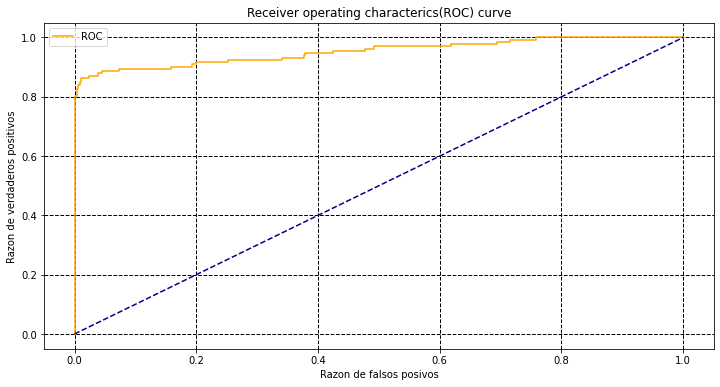

In [44]:
frp, tpr, threshold = roc_curve(y_test, lrus_pp1)
plot_roc_auc(frp, tpr)

In [45]:
# Verificamos Exactitud
accuracy_score(y_test, LrUpsampled_pred)

0.9826971152495716

In [46]:
# f1 score
f1_score(y_test, LrUpsampled_pred)

0.15616438356164383

Confusion matrix, without normalization
[[69856  1214]
 [   18   114]]
Normalized confusion matrix
[[0.98291825 0.01708175]
 [0.13636364 0.86363636]]


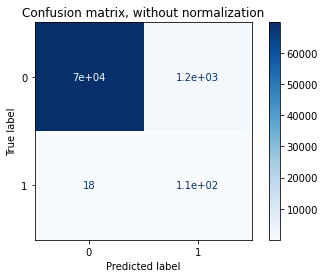

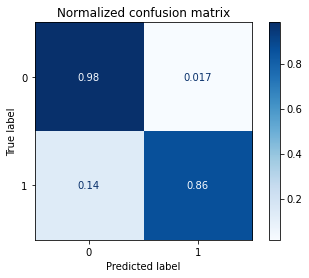

In [47]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(LrUpsampled, X_test, y_test, display_labels=['0','1'], cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show()

In [48]:
recall_score(y_test, LrUpsampled_pred)

0.8636363636363636

Nuestro puntaje de precisión disminuyó después del muestreo ascendente, pero el modelo ahora predice ambas clases de manera más equitativa, lo que lo convierte en una mejora sobre nuestra regresión logística simple anterior.

#Submuestreo de la mayoria 



El submuestreo se puede definir como la eliminación de algunas observaciones de la clase mayoritaria. El submuestreo puede ser una buena opción cuando tiene una toneladas de datos: piense en millones de filas. Pero un inconveniente del submuestreo es que estamos eliminando información que puede ser valiosa.

Nuevamente usaremos el módulo de remuestreo de Scikit-Learn para eliminar aleatoriamente muestras de la clase mayoritaria.

In [49]:
 #continuo usando nuestras clases separadas de fraude y no fraude desde arriba

# disminución de la mayoría
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = len(fraud), # match minority n
                                random_state =state) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# verificar el recuentos nuevos de clases
downsampled.Class.value_counts()

1    360
0    360
Name: Class, dtype: int64

In [0]:
# Intentando la regresión logística nuevamente con el conjunto de datos con submuestreo

y_train_ds = downsampled.Class
X_train_ds = downsampled.drop('Class', axis=1)

Lrdownsampled = LogisticRegression(solver='liblinear')
Lrdownsampled = Lrdownsampled.fit(X_train_ds, y_train_ds)

LrUndersampled_pred = Lrdownsampled.predict(X_test)
LrUs_pp = Lrdownsampled.predict_proba(X_test)

In [51]:
LrUs_pp = LrUs_pp [:,1]
auc = roc_auc_score(y_test, LrUs_pp  )#funcion para encontrar el auc
print('AUC: %.2f' % auc)

AUC: 0.97


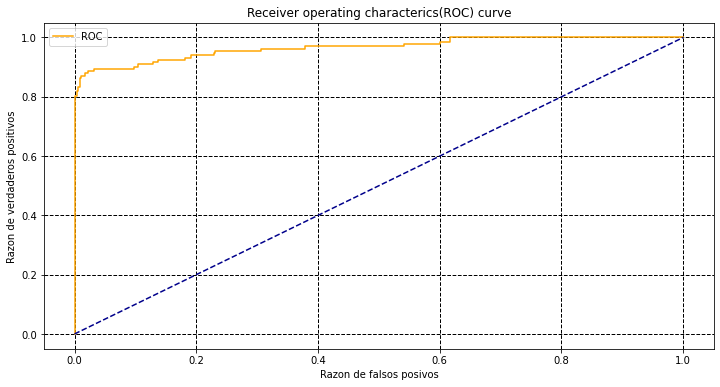

In [52]:
frp, tpr, threshold = roc_curve(y_test,  LrUs_pp )
plot_roc_auc(frp, tpr)

In [53]:
# f1 score
f1_score(y_test, LrUndersampled_pred)

0.1029476462824461

In [54]:
# Checking accuracy
accuracy_score(y_test, LrUndersampled_pred)

0.9713631639560687

Confusion matrix, without normalization
[[69046  2024]
 [   15   117]]
Normalized confusion matrix
[[0.97152104 0.02847896]
 [0.11363636 0.88636364]]


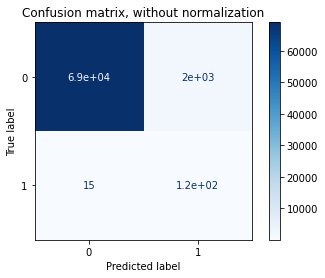

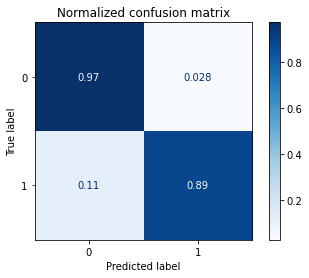

In [55]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None), ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(Lrdownsampled , X_test, y_test, display_labels=['0','1'], cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix) 
plt.show()

In [56]:
recall_score(y_test,  LrUndersampled_pred)

0.8863636363636364

#Generate Synthetic Samples

SMOTE o Synthetic Minority Oversampling Technique es un algoritmo popular para crear observaciones sintéticas de la clase minoritaria.

In [57]:
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_us, y_train_us)

In [59]:
X_res.shape, y_res

((426490, 30), array([0, 0, 0, ..., 1, 1, 1]))

In [0]:
smote = LogisticRegression(solver='liblinear')
smote = smote.fit(X_res, y_res)

smote_pred = smote.predict(X_test)
smote_pp = smote.predict_proba(X_test)

In [61]:
smote_pp = smote_pp[:,1]
auc = roc_auc_score(y_test, smote_pp )#funcion para encontrar el auc
print('AUC: %.2f' % auc)

AUC: 0.95


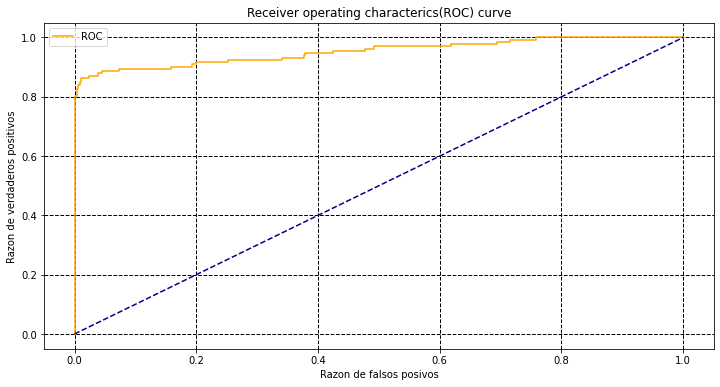

In [62]:
frp, tpr, threshold = roc_curve(y_test,  smote_pp )
plot_roc_auc(frp, tpr)

In [63]:
# Checking accuracy
accuracy_score(y_test, smote_pred)

0.9826971152495716

In [64]:
# f1 score
f1_score(y_test, smote_pred)

0.15616438356164383

Confusion matrix, without normalization
[[69856  1214]
 [   18   114]]
Normalized confusion matrix
[[0.98291825 0.01708175]
 [0.13636364 0.86363636]]


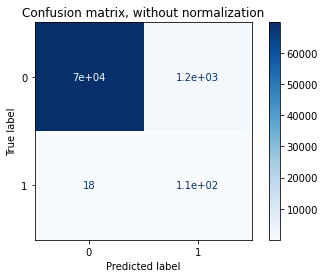

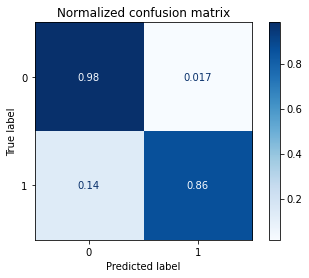

In [65]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(smote, X_test, y_test,
                                 display_labels=['0','1'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [66]:
recall_score(y_test, smote_pred)

0.8636363636363636

#Aprendizaje sensitivo al costo 

Support Vector MachinePython

In [0]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

In [0]:
X = data.loc[:, data.columns!=target]

In [0]:
Y = data.loc[:, data.columns==target]

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.33, 
                                                    random_state=state)

In [115]:
unique_classes = list(data[target].unique())
print(data[target].value_counts())
unique_classes

0    284315
1       492
Name: Class, dtype: int64


[0, 1]

In [0]:
out_dict = {}
for classes in unique_classes:
    out_dict[classes] = data.shape[0]/((data.loc[data[target] == classes].shape[0])
                                     *len(unique_classes))

In [119]:
out_dict

{0: 0.5008652375006595, 1: 289.4380081300813}

In [120]:
print (X_train.shape, y_train.shape)

(190820, 30) (213605,)


In [122]:
clf = LogisticRegression(class_weight='balanced').fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [92]:
y_train.head()

264873    0
163821    0
72083     0
196949    0
126213    0
Name: Class, dtype: int64

In [124]:
class_weight.compute_class_weight('balanced', np.unique(y_train), Y_train[target])

array([  0.50085041, 294.47530864])

In [0]:
Y_Test_Pred = clf.predict(X_test)
clf_pp = clf.predict_proba(X_test)

In [128]:
# Checking accuracy
accuracy_score(y_test, smote_pred)

0.9826971152495716

In [129]:
# f1 score
f1_score(y_test, smote_pred)

0.15616438356164383

Confusion matrix, without normalization
[[90485  3334]
 [   15   153]]
Normalized confusion matrix
[[0.96446349 0.03553651]
 [0.08928571 0.91071429]]


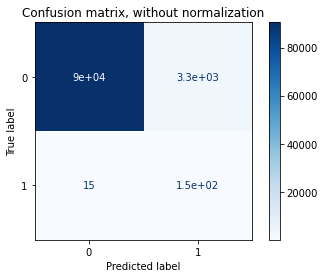

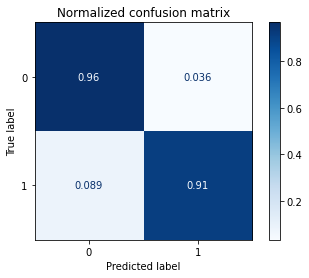

In [131]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, Y_test,
                                 display_labels=['0','1'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [132]:
recall_score(y_test, smote_pred)

0.8636363636363636

In [137]:
clf_pp

array([0.07440294, 0.14278334, 0.04928816, ..., 0.15934478, 0.08600511,
       0.10358023])

In [139]:
# clf_pp = clf_pp[:,1]
auc = roc_auc_score(Y_test, clf_pp )#funcion para encontrar el auc
print('AUC: %.2f' % auc)

AUC: 0.97


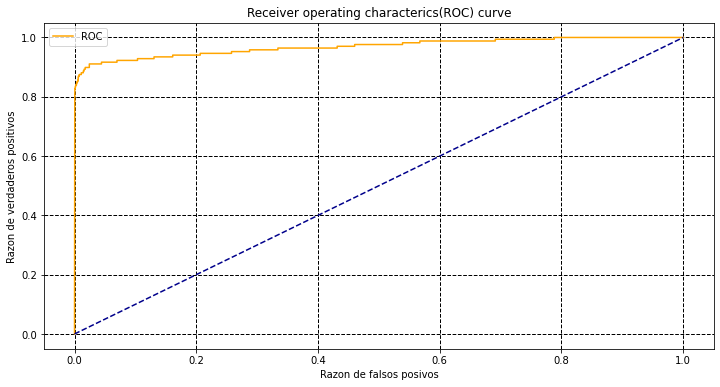

In [140]:
frp, tpr, threshold = roc_curve(Y_test,  clf_pp )
plot_roc_auc(frp, tpr)

#Conclusion

¡La disminución de muestreo produjo una puntuación de recuperación más alta que el muestreo superior! Mi preocupación aquí es la pequeña cantidad de muestras totales que utilizamos para entrenar el modelo.

Cubrimos 5 métodos diferentes para tratar con conjuntos de datos desequilibrados:

Cambiar la métrica de rendimiento

*   Cambiar la métrica de rendimiento
*   Sobremuestreo de clase minoritaria
*   Clase mayoritaria de submuestreo
*   Cambiar el algoritmo
*   Generar muestras sintéticas.
*   Penalización de Algoritmos con Aprendizaje sensitivo al costo  

Estos son solo algunos de los muchos métodos posibles para tratar cuando se trata de conjuntos de datos desequilibrados, y no una lista exhaustiva. Algunos otros métodos a tener en cuenta son la recopilación de más datos o la elección de diferentes proporciones de muestreo: ¡no es necesario tener exactamente una proporción 1: 1! Siempre debe intentar varios enfoques y luego decidir cuál es el mejor para su problema.